In [206]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.feature_selection import SelectFromModel
import graphviz
import warnings
warnings.filterwarnings('ignore')

In [181]:
df = pd.read_csv('usedCarListingCleaned.csv')
del df['Unnamed: 0']
df=df[df.title != 'Lemon'] # get rid of one record of Lemon car 
df['year'] = df['year'].astype(object)
print(df.shape)
df.head()

(9701, 22)


,year,make,model,sub_model,city,state,mileage,price,exterior_color,interior_color,...,engine,transmission,drive_type,fuel_type,popular_feature,cpo,num_accident,usage_type,title,num_owner
0,2017,Ford,Fusion,SE FWD,Blue Mound,TX,32253,14400,White Platinum Metallic Tri-Coat,Medium Light Stone,...,1.5L Inline-4 Gas Turbocharged,Automatic,FWD,Gas,"['Navigation', 'Backup Camera', 'Cruise Contro...",False,0,Fleet or Mixed Use,Clean,1
1,2007,BMW,6,650i Convertible,Stanton,CA,59664,11499,Mineral Silver Metallic,Tan,...,4.8L V-8 Gas,Automatic,RWD,Gas,[],False,0,Fleet or Mixed Use,Clean,3
2,2019,Kia,Optima,LX,Thornton,CO,4816,18586,Ebony Black,Black,...,2.4L Inline-4 Gas,Automatic,FWD,Gas,"['Cruise Control', 'Lane Keep Assist', 'Blueto...",True,1,Personal or Rental Use,Clean,2
3,2017,Ford,Fusion,SE FWD,Denver,NC,99515,8999,Shadow Black,Black,...,2.5L Inline-4 Gas,Automatic,FWD,Gas,"['Cruise Control', 'Bluetooth', 'Backup Camera']",False,1,Fleet or Mixed Use,Clean,2
4,2017,Hyundai,Elantra,SE 2.0L Sedan Automatic (alt),Wesley Chapel,FL,117200,6109,Quartz White Pearl,Beige,...,2.0L Inline-4 Gas,Automatic,FWD,Gas,"['Cruise Control', 'Bluetooth']",False,1,Personal or Rental Use,Clean,1


In [182]:
## Check levels for different categorical variables

In [183]:
cat_cols = ['year', 'make', 'model', 'sub_model', 'city', 'state', 'exterior_color', 'interior_color',
           'engine', 'transmission', 'drive_type', 'fuel_type', 'cpo', 'usage_type', 'title']
num_cols = ['mileage', 'mpg_city', 'mpg_hwy', 'num_accident', 'num_owner']
res_y = 'price'

In [184]:
for column in cat_cols:
    print('The number of unique level for {} is {}'.format(column, len(df[column].unique())) )

The number of unique level for year is 24
The number of unique level for make is 51
The number of unique level for model is 425
The number of unique level for sub_model is 1888
The number of unique level for city is 1594
The number of unique level for state is 50
The number of unique level for exterior_color is 1057
The number of unique level for interior_color is 559
The number of unique level for engine is 181
The number of unique level for transmission is 2
The number of unique level for drive_type is 4
The number of unique level for fuel_type is 7
The number of unique level for cpo is 2
The number of unique level for usage_type is 2
The number of unique level for title is 4


#### Since we only have 9701 data records, and after the train-test-split, we may only have very limited data for training. Therefore, it's a good idea to drop catagorical variables that have too many levels.

Since from last notebook, we noticed that for state variable, it does not seem to impact the price since the price distribution is very similar when we compare CA and non-CA, CA and TX. Therefore, I will also drop state variable in order to reduce the number of columns after onehot encoding.

I will drop categorical variables including state, model, sub_model, city, exterior_color, interior_color, engine

In [185]:
left_cat_cols=['year', 'make',  'transmission', 'drive_type', 'fuel_type', 'cpo', 'usage_type', 'title']

## One hot encoding and Train test split

The reason for doing onehot encoding before train test split is that: no matter how I do the split, there will always be level mismatch in train and test data, which will give different number of predictors in train and test datasets.

To overcome this, I decided to do onehot encoding before the train test split.

Do log transformation for price

In [186]:
final_cols = left_cat_cols + num_cols
y = np.log(df[res_y].values)

In [187]:
%%time
X = pd.get_dummies(df[final_cols], drop_first=True)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1, random_state=10)
print(X_tr.shape, X_te.shape, y_tr.shape, y_te.shape)

(8730, 93) (971, 93) (8730,) (971,)
CPU times: user 38.7 ms, sys: 4.35 ms, total: 43.1 ms
Wall time: 41.2 ms


## Standardization for numeric features

In [188]:
scaled_num_cols = ['scaled_'+col for col in num_cols]
num_scaler = StandardScaler().fit(X_tr[num_cols])

In [189]:
%%time
X_tr_num_scaled = pd.DataFrame(num_scaler.transform(X_tr[num_cols]), 
                                  index = X_tr.index, columns = scaled_num_cols)

CPU times: user 4.28 ms, sys: 1.01 ms, total: 5.29 ms
Wall time: 4.23 ms


In [190]:
%%time
X_te_num_scaled = pd.DataFrame(num_scaler.transform(X_te[num_cols]), index = X_te.index, columns = scaled_num_cols)

CPU times: user 3.96 ms, sys: 1.34 ms, total: 5.3 ms
Wall time: 4.09 ms


In [191]:
print(X_tr_num_scaled.shape, X_te_num_scaled.shape)

(8730, 5) (971, 5)


## Combine onehoted categorical columns and standardized numerical columns for both train and test data

In [192]:
X_tr_final = pd.concat([X_tr_num_scaled, X_tr.drop(num_cols, axis=1)], axis=1)
X_te_final = pd.concat([X_te_num_scaled, X_te.drop(num_cols, axis=1)], axis=1)
print(X_tr_final.shape, X_te_final.shape)

(8730, 93) (971, 93)


## Check the train test data in terms of distribution

I found that the distributions of response variable 'price' and one of the indicator variable 'mileage' in train and test data are very similar, which is good.

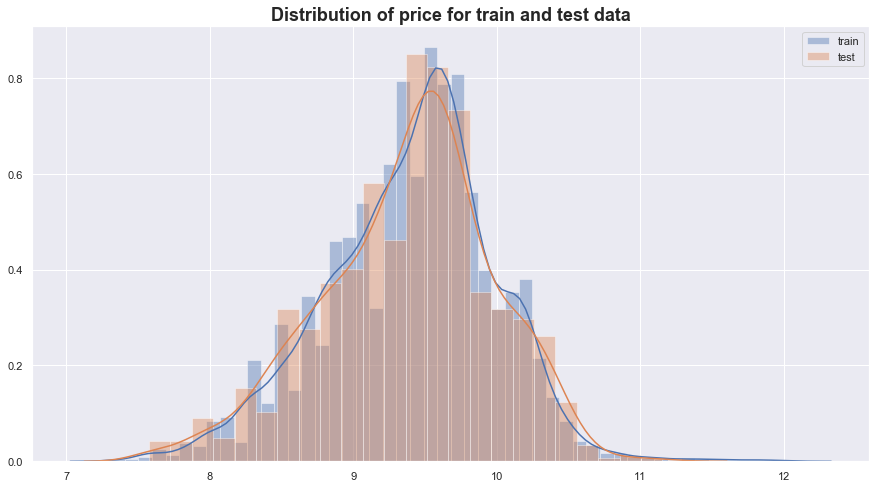

In [193]:
sns.set(rc={"figure.figsize": (15, 8)})
sns.distplot(y_tr,hist_kws={"label":'train'})
sns.distplot(y_te,hist_kws={"label":'test'})
plt.title('Distribution of price for train and test data',fontsize=18,fontweight="bold")
plt.legend()
plt.show()

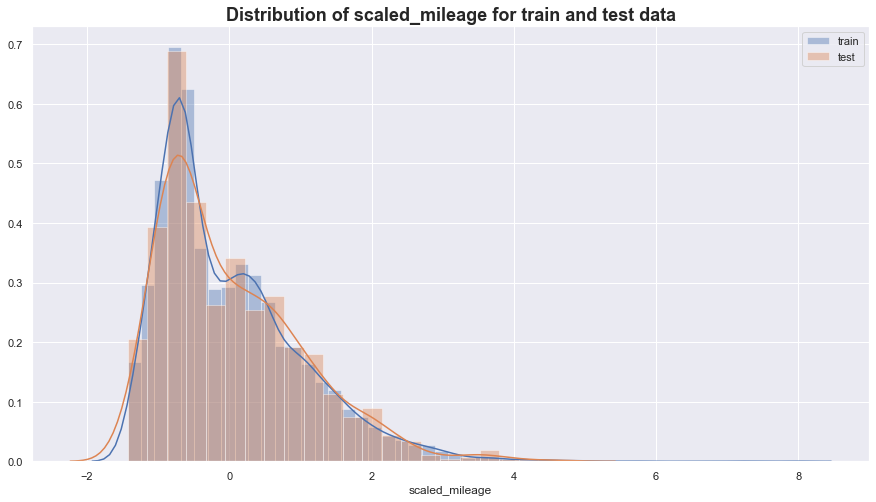

In [194]:
sns.set(rc={"figure.figsize": (15, 8)})
sns.distplot(X_tr_final.scaled_mileage,hist_kws={"label":'train'})
sns.distplot(X_te_final.scaled_mileage,hist_kws={"label":'test'})
plt.title('Distribution of scaled_mileage for train and test data',fontsize=18,fontweight="bold")
plt.legend()
plt.show()

# xgboost model

In [195]:
### train validataion split
X_tr_final.shape, y_tr.shape

((8730, 93), (8730,))

In [197]:
X_tr, X_val, y_train, y_val = train_test_split(X_tr_final, y_tr, test_size=0.2, random_state=1024)
print('Training data dimensions are {} for X_tr, {} for y_train'.format(X_tr.shape, y_train.shape))
print('Validation data dimensions are {} for X_val, {} for y_val'.format(X_val.shape, y_val.shape))

Training data dimensions are (6984, 93) for X_tr, (6984,) for y_tr
Validation data dimensions are (1746, 93) for X_val, (1746,) for y_val


In [198]:
## Create DMatrix for xgboost model
train_dmatrix = xgb.DMatrix(X_tr, label=y_train)
val_dmatrix = xgb.DMatrix(X_val, label=y_val)
eval_setting = [(train_dmatrix, 'train'), (val_dmatrix, 'eval')]

In [212]:
%%time
xgb_params = {'colsample_bytree': 0.4,
             'eta': 0.1,
             'gamma': 2,
             'max_depth': 4,
             'min_child_weight': 100,
             'objective': 'reg:linear',
             'seed': 1024,
             'subsample': 1,
             'eval_metric': 'rmse'
             }
model = xgb.train(params=xgb_params,
                 dtrain=train_dmatrix,
                 num_boost_round=500,
                 evals=eval_setting,
                 early_stopping_rounds=50,
                 verbose_eval=100
                 )
best_iteration = model.best_iteration
best_score = model.best_score
print('Model best score is {}, best iteration is {}'.format(best_score, best_iteration))

[04:38:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:8.02888	eval-rmse:8.03368
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[100]	train-rmse:0.274416	eval-rmse:0.273374
[200]	train-rmse:0.26546	eval-rmse:0.265976
[300]	train-rmse:0.260849	eval-rmse:0.261714
[400]	train-rmse:0.258251	eval-rmse:0.259458
Stopping. Best iteration:
[380]	train-rmse:0.258251	eval-rmse:0.259458

Model best score is 0.259458, best iteration is 380
CPU times: user 8.35 s, sys: 31.1 ms, total: 8.38 s
Wall time: 8.41 s


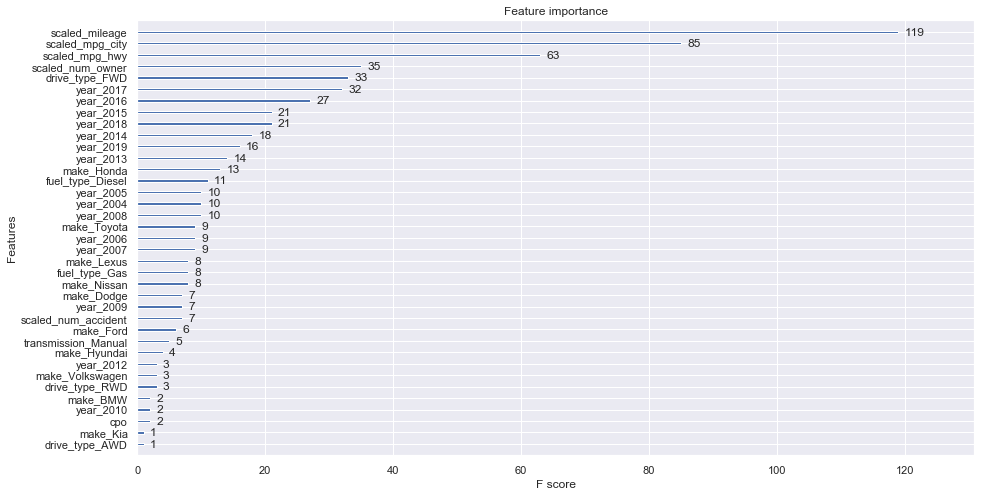

In [201]:
xgb.plot_importance(model)


The most important features include mileage, mpg (mpg_city, hwy) and number of previous owners.

Mileage, mpg_city and mpg_hwy take the dominant effects of feature importance

## Making prediction on test data

In [215]:
test_dmatrix=xgb.DMatrix(X_te_final)
y_pred = pd.Series(model.predict(test_dmatrix))
pred_price = y_pred.apply(np.exp).clip(lower=0.)

In [221]:
mae = np.mean(abs(pred_price-np.exp(y_te)))
print('The MAE for test data is about ${}'.format(mae))

The MAE for test data is about $2440.4372183959836


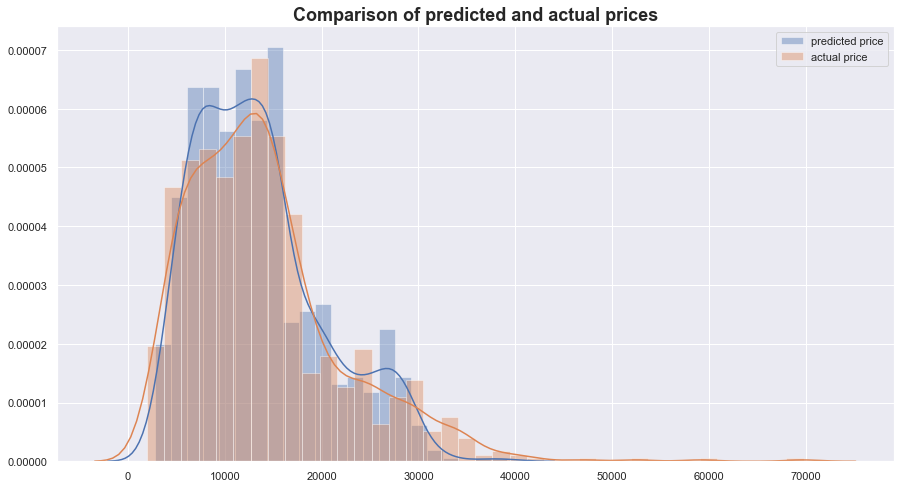

In [223]:
sns.set(rc={"figure.figsize": (15, 8)})
sns.distplot(pred_price,hist_kws={"label":'predicted price'})
sns.distplot(np.exp(y_te),hist_kws={"label":'actual price'})
plt.title('Comparison of predicted and actual prices',fontsize=18,fontweight="bold")
plt.legend()
plt.show()